# Hybrid quantum transfer learning for crack image classification on NISQ hardware

**This notebook is meant to support the understanding of our paper [Hybrid quantum transfer learning for crack image classification on NISQ hardware](https://arxiv.org/abs/2307.16723).**

This notebook is mainly based on PennyLane's demo [Quantum transfer learning](https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning/). We show, how to apply that notebook to images of concrete. 

It is an example of a hybrid network for image classification, developed according to the *classical-to-quantum transfer learning* scheme presented by Andrea Mari et al. in [Transfer learning in hybrid classical-quantum neural networks](https://arxiv.org/abs/1912.08278). 

This notebook is inspired by the official PyTorch  [tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by Sasank Chilamkurthy.

The starting point is a convolutional neural network—ResNet18, introduced by Microsoft in 2016 which is pre-trained on the public ImageNet dataset. We replace the last fully connected layer with a *dressed quantum circuit* that we train on a different dataset. Specifically, we focus on two classes of insect images: *crack* and *no_crack*. 

<div style="overflow: auto;">
    <img src="https://www.itwm.fraunhofer.de/content/businesscards/ITWM/bv/alexander_geng/jcr:content/businesscard/image.img.1col.jpg/1660740872670/230x230-itwm-bv-geng-alexander.jpg" alt="Landscape" width="100" style="float: left; margin-right: 10px;"/>
    <p style="margin: 0;"> _________________________________</p>
    <p style="margin: 0;">Author: Alexander Geng.</p>
    <p style="margin: 0;">Published: December 5, 2023. </p>
    <p style="margin: 0;">Last updated: December 5, 2023. </p>
    <p style="margin: 0;"> _________________________________</p>
</div>

## Scheme crack classification

![alt text](scheme.png "scheme crack classification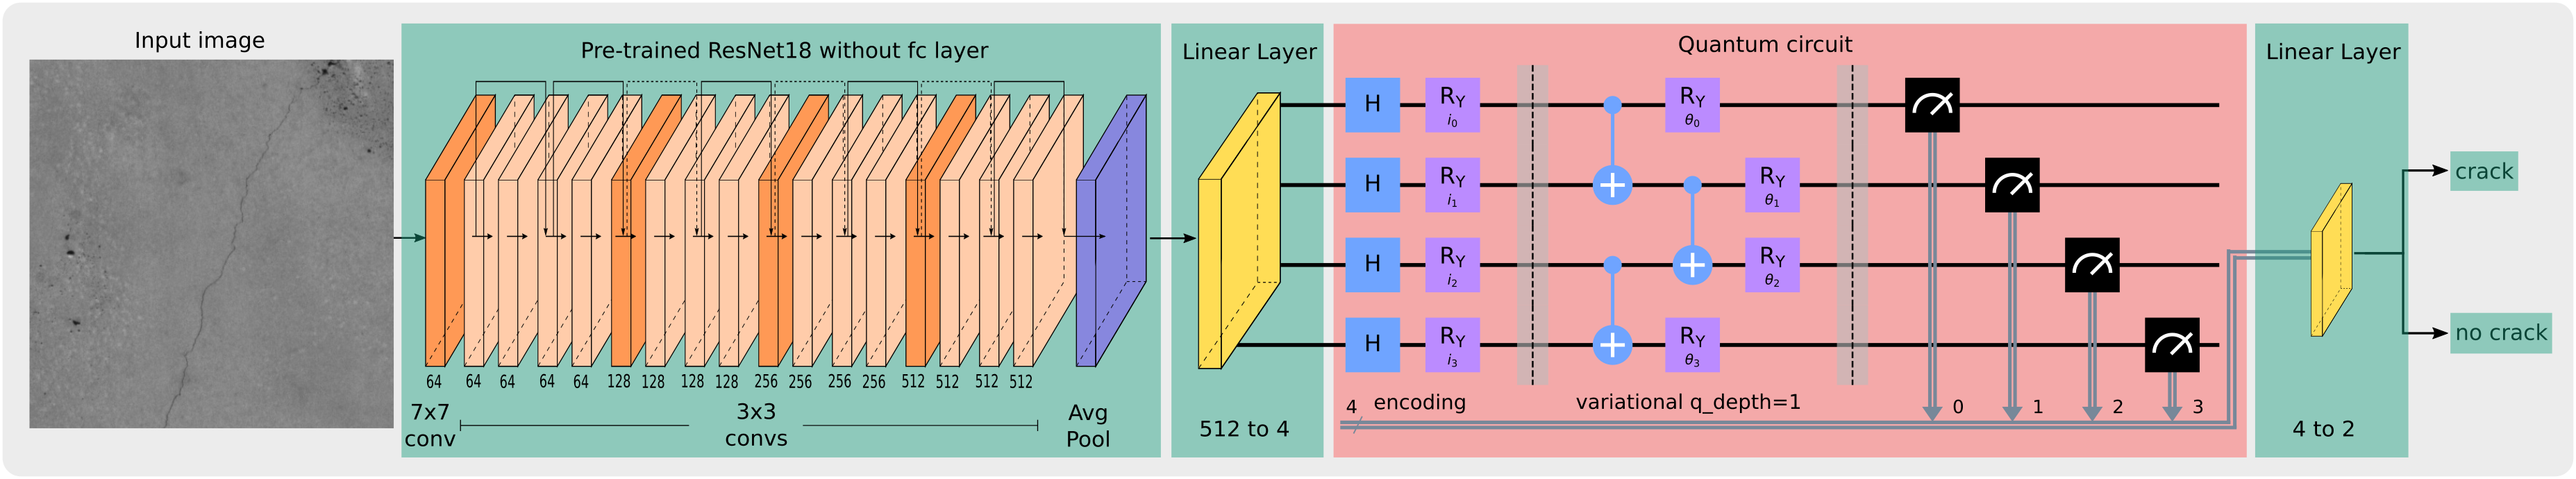")

## General setup
**Important:** this code makes use of the machine learning framework *PyTorch*, which is assumed to be correctly installed.

The main imported packages are: some common PyTorch libraries, the quantum 
software framework `pennylane` and the python plotting library `matplotlib`.

<div class="alert alert-block alert-success">
    The folder structure for the code should be the following:
<div>    

```
project
│   environment.yml
│   requirements.txt
|   crack_classification.ipynb
|   scheme.png
|
└───models
└───best_models
└───loss_accuracy
│
└───sub_12img
    │   
    └───test
        │   
        └───cracks
        │   
        └───no_cracks
    │   
    └───train
        │   
        └───cracks
        │   
        └───no_cracks
    │   
    └───val
        │   
        └───cracks
        │   
        └───no_cracks
```

In [ ]:
# !pip3 install pennylane
# !pip3 install pennylane-qiskit

In [ ]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import os
import copy
from PIL import Image

env: OMP_NUM_THREADS=1


Setting of the main parameters of the network model and of the training process.<br>
**Remark:** To reproduce the results of [the paper], `num_epochs` should be set to 30 which may take many hours. We suggest to first try with `num_epochs=1`, just to check that everything runs smoothly.

In [ ]:
n_qubits = 4                     # Number of qubits
quantum = True                   # If set to "False", the dressed quantum circuit is replaced by 
                                 # An enterily classical net (defined by the next parameter). 
classical_model = '512_nq_2'     # Possible choices: '512_2','512_nq_2','551_512_2'. 
step = 0.0004                    # Learning rate
batch_size = 4                   # Number of samples for each training step
num_epochs = 10                   # Number of training epochs #30
q_depth = 1                      # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1         # Learning rate reduction applied every 10 epochs.                       
q_delta = 0.01                   # Initial spread of random quantum weights
rng_seed = 698                     # Seed for random number generator
start_time = time.time()         # Start of the computation timer

### Import IBM backends

In [ ]:
from pprint import pprint # pretty printer
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider import least_busy

# Initialize an empty string variable named 'token'.
# Insert your IBM token here if you want to access IBM's real backends.
token = ''

# Save the IBM account using the provided token. Overwrite the existing account if it exists.
IBMProvider.save_account(token, overwrite=True)

# Create an instance of the IBMProvider class.
provider = IBMProvider()

# Define a function named 'backend_filter_num_circuit' that filters backends based on specific criteria.
# The function checks if the backend has a number of qubits greater than or equal to 'n_qubits',
# is not a simulator, is operational, and has an active status message.
def backend_filter_num_circuit(b):
    return (
        b.configuration().n_qubits >= n_qubits and
        not b.configuration().simulator and
        b.status().operational == True and
        b.status().status_msg == 'active'
    )

# Get a list of backends supported by the provider that match the filter criteria defined in 'backend_filter_num_circuit'.
backends_list = provider.backends(filters=backend_filter_num_circuit)

# Display the current supported backends that meet the specified criteria.
pprint(backends_list)

# Choose the least busy backend from the filtered backends obtained earlier.
backend_real = least_busy(provider.backends(filters=backend_filter_num_circuit))

# Print the least busy backend selected.
print(backend_real)

### Choose device

Here you have many choices. As in the paper, we focus mostly on either PennyLane's default qubit setting, IBM's qasm_simulator, or IBM's real quantum devices.
Feel free to change as you wish.

In [ ]:
dev = qml.device('default.qubit', wires=n_qubits)
# dev = qml.device('qiskit.aer', wires=n_qubits, backend='qasm_simulator', shots=20000)
# dev = qml.device('qiskit.ibmq', wires=n_qubits, backend=backend_real.name(), provider=provider, shots=20000)

Configure PyTorch to use CUDA, only if available. Otherwise simply use the CPU.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# device = torch.device("cpu")

## Dataset loading from PennyLane's demo

**Important:** The dataset containing images of *ants* and *bees* can be downloaded [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and should be extracted in the subfolder `[current directory]/data/hymenoptera_data`. 

This is a very small dataset (roughly 200 images), too small for training from scratch a deep network, however it is enough for a *transfer learning* approach. 


The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, *etc.* .

## Dataset loading cracks

We use $224\times 224$ gray-value images of concrete. The total size of the dataset is $1,223$ images. $723$ of them contain thin cracks of about $1-2$ pixel width, $500$ are without.

### Procedure for splitting

For reproducibility, we set up one splitting and used that for the experiments.

In [ ]:
# import shutil
# import os

# def split_dataset_into_3(path_to_dataset, train_ratio, valid_ratio):
#     """
#     split the dataset in the given path into three subsets(test,validation,train)
#     :param path_to_dataset:
#     :param train_ratio:
#     :param valid_ratio:
#     :return:
#     """
#     _, sub_dirs, _ = next(iter(os.walk(path_to_dataset)))  # retrieve name of subdirectories
#     sub_dir_item_cnt = [0 for i in range(len(sub_dirs))]  # list for counting items in each sub directory(class)

#     # directories where the splitted dataset will lie
#     dir_train = os.path.join(os.path.dirname(path_to_dataset), 'train')
#     dir_valid = os.path.join(os.path.dirname(path_to_dataset), 'val')
#     dir_test = os.path.join(os.path.dirname(path_to_dataset), 'test')

#     for i, sub_dir in enumerate(sub_dirs):

#         dir_train_dst = os.path.join(dir_train, sub_dir)  # directory for destination of train dataset
#         dir_valid_dst = os.path.join(dir_valid, sub_dir)  # directory for destination of validation dataset
#         dir_test_dst = os.path.join(dir_test, sub_dir)  # directory for destination of test dataset

#         # variables to save the sub directory name(class name) and to count the images of each sub directory(class)
#         class_name = sub_dir
#         sub_dir = os.path.join(path_to_dataset, sub_dir)
#         sub_dir_item_cnt[i] = len(os.listdir(sub_dir))
#         print(range(round(sub_dir_item_cnt[i] * train_ratio)),range(round(sub_dir_item_cnt[i] * train_ratio),
#                               round(sub_dir_item_cnt[i] * (train_ratio + valid_ratio))), range(round(sub_dir_item_cnt[i] * (train_ratio + valid_ratio)), sub_dir_item_cnt[i]) )
#         items = os.listdir(sub_dir)
        
#         # transfer data to trainset
#         for item_idx in range(round(sub_dir_item_cnt[i] * train_ratio)):
#             if not os.path.exists(dir_train_dst):
#                 os.makedirs(dir_train_dst)

#             source_file = os.path.join(sub_dir, items[item_idx])
#             dst_file = os.path.join(dir_train_dst, items[item_idx])
#             shutil.copyfile(source_file, dst_file)

#         # transfer data to validation
#         for item_idx in range(round(sub_dir_item_cnt[i] * train_ratio),
#                               round(sub_dir_item_cnt[i] * (train_ratio + valid_ratio))):
#             if not os.path.exists(dir_valid_dst):
#                 os.makedirs(dir_valid_dst)

#             source_file = os.path.join(sub_dir, items[item_idx])
#             dst_file = os.path.join(dir_valid_dst, items[item_idx])
#             shutil.copyfile(source_file, dst_file)

#         # transfer data to testset
#         for item_idx in range(round(sub_dir_item_cnt[i] * (train_ratio + valid_ratio)), sub_dir_item_cnt[i]):
#             if not os.path.exists(dir_test_dst):
#                 os.makedirs(dir_test_dst)

#             source_file = os.path.join(sub_dir, items[item_idx])
#             dst_file = os.path.join(dir_test_dst, items[item_idx])
#             shutil.copyfile(source_file, dst_file)

#     return

We are unfortunately not allowed to publish the complete dataset. What is published here is intended more for demonstration purposes to illustrate the functionality of the code.

The subset of the original data contains 12 images with cracks and 12 without cracks per class for training, validation, and testing purposes.

In [ ]:
import os
cwd = os.getcwd()
dataset_folder=cwd+'/used_datasets/'
folder_name='subset_12img'
data_dir = dataset_folder+folder_name
print(cwd)
print(dataset_folder)
print(data_dir)

In [ ]:
# split_dataset_into_3(dataset_folder+'original/', 0.04, 0.04)

In [ ]:
# Dictionary containing different transforms for 'train', 'val', and 'test' sets
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),  # Convert PIL Image to tensor
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),  # Convert PIL Image to tensor
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),  # Convert PIL Image to tensor
    ]),
}

# Function to load images using PIL (Python Imaging Library)
def custom_pil_loader(path):
    # Open path as a file to avoid ResourceWarning
    with open(path, 'rb') as f:
        img = Image.open(f)  # Open image using PIL
        img.load()
        return img  # Return the loaded image

# Create ImageFolder datasets for 'train', 'val', and 'test' using the specified transforms and custom loader
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms[x],
        loader=custom_pil_loader
    ) for x in ['train', 'val', 'test']
}

# Determine the sizes of 'train', 'val', and 'test' datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Obtain class names from the 'train' set
class_names = image_datasets['train'].classes

# Initialize data loaders for 'train', 'val', and 'test' datasets
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=batch_size,  # Set batch size for loading images
        shuffle=True  # Shuffle the data for each epoch
    ) for x in ['train', 'val', 'test']
}

# Function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    # Convert tensor to a numpy array and transpose the dimensions for display
    inp = inp.numpy().transpose((1, 2, 0)).astype('uint8')
    
    # Create a figure to display the image
    plt.figure(figsize=(20, 10))
    plt.imshow(inp)  # Show the image
    
    if title is not None:
        plt.title(title)  # Set the title if provided


Let us show a batch of the test data, just to have an idea of the classification problem.<br>
*Hint:* re-run the next cell to see more samples.

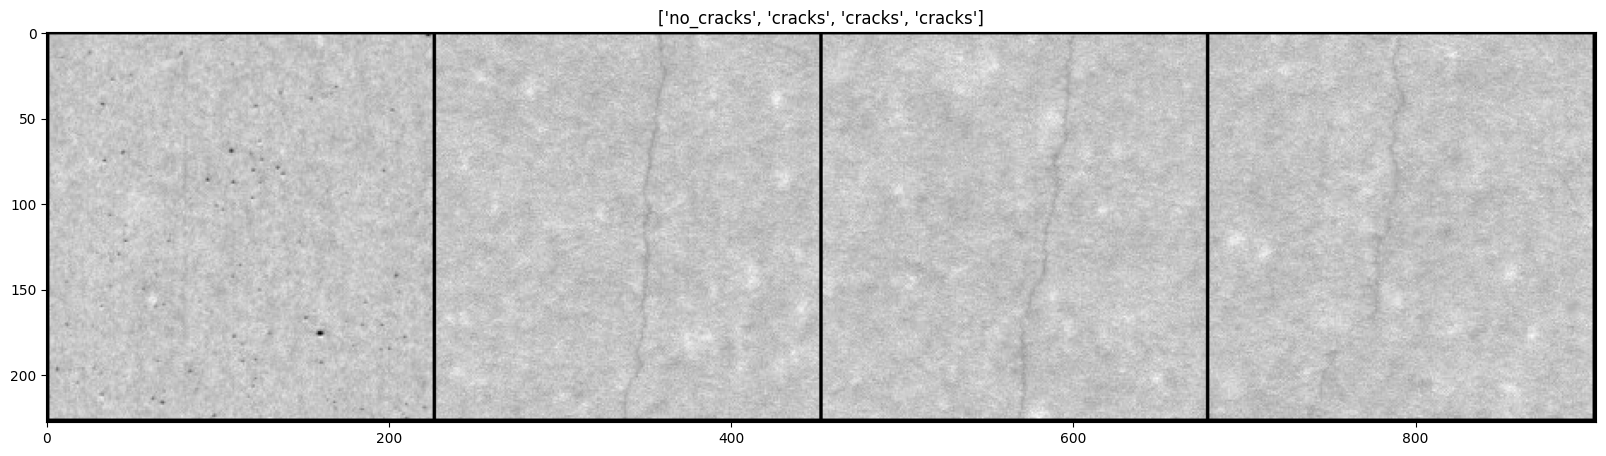

In [39]:
# Get a batch of training data from the 'train' dataloader
inputs, classes = next(iter(dataloaders['train']))

# Repeat the input batch along the second dimension (channels) to match the requirements for using a pretrained ResNet18 model
inputs = inputs.repeat(1, 3, 1, 1)

# Normalize the input data to the range [0, 255]
arr = inputs
new_arr = ((arr - arr.min()) * (1 / (arr.max() - arr.min()) * 255))

# Make a grid of images from the batch using torchvision's utility function
out = torchvision.utils.make_grid(new_arr)

# Display the grid of images using the 'imshow' function, along with corresponding class names as the title
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
inputs.shape

## Hybrid transfer learning model (classical-to-quantum).

We first define some quantum layers that will compose the quantum circuit.

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    Args:
    - nqubits (int): Number of qubits
    
    Applies Hadamard gates to each qubit in the specified range of wires.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)  # Apply Hadamard gate to each qubit in the range

def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    Args:
    - w (list): List of rotation angles for each qubit
    
    Applies rotation gates around the y-axis to each qubit based on the provided angles.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)  # Apply RY gate to each qubit with specified rotation angles

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    Args:
    - nqubits (int): Number of qubits
    
    Applies a sequence of CNOT gates to create entanglement between qubits.
    """
    # Loop over even indices, applying CNOT gates between adjacent qubits
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])  # Apply CNOT gate between adjacent qubits

    # Loop over odd indices, applying CNOT gates between adjacent qubits (shifted)
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices: i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])  # Apply CNOT gate between shifted adjacent qubits


Now we define the quantum circuit through the PennyLane qnode decorator
.

The structure is that of a typical variational quantum circuit:

-   **Embedding layer:** All qubits are first initialized in a balanced
    superposition of *up* and *down* states, then they are rotated
    according to the input parameters (local embedding).
-   **Variational layers:** A sequence of trainable rotation layers and
    constant entangling layers is applied.
-   **Measurement layer:** For each qubit, the local expectation value
    of the $Z$ operator is measured. This produces a classical output
    vector, suitable for additional post-processing.



In [ ]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    Args:
    - q_input_features (tensor): Quantum input features
    - q_weights_flat (tensor): Flattened trainable quantum weights
    
    This function defines the structure of a variational quantum circuit using PennyLane's QNode decorator.
    """

    # Reshape weights into a 2D array
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start the quantum circuit in a state |+>, which is unbiased with respect to |0> and |1>
    H_layer(n_qubits)  # Apply Hadamard gates to all qubits

    # Embed input features into the quantum circuit
    RY_layer(q_input_features)  # Apply rotations around y-axis based on input features

    # Apply a sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)  # Apply entangling CNOT gates between qubits
        RY_layer(q_weights[k])  # Apply rotations based on trainable weights

    # Calculate the expectation values in the Z basis for each qubit
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]

    # Return the tuple of expectation values
    return tuple(exp_vals)


Dressed quantum circuit
=======================

We can now define a custom `torch.nn.Module` representing a *dressed*
quantum circuit.

This is a concatenation of:

-   A classical pre-processing layer (`nn.Linear`).
-   A classical activation function (`torch.tanh`).
-   A constant `np.pi/2.0` scaling.
-   The previously defined quantum circuit (`quantum_net`).
-   A classical post-processing layer (`nn.Linear`).

The input of the module is a batch of vectors with 512 real parameters
(features) and the output is a batch of vectors with two real outputs
(associated with the two classes of images: *ants* and *bees*).


In [ ]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        Initializes the layers and parameters.
        """

        super().__init__()

        # Define a pre-network layer that reduces the feature dimension from 512 to n_qubits
        self.pre_net = nn.Linear(512, n_qubits)

        # Define quantum parameters as learnable parameters (weights) of the network
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))

        # Define a post-network layer that maps from n_qubits to 2 output classes
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors move through the *dressed* quantum net.
        """

        # Obtain the input features for the quantum circuit and scale them for quantum processing
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0  # Scale input features for quantum circuit input

        # Apply the quantum circuit (quantum_net) to each element of the batch and collect outputs
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))  # Concatenate quantum circuit outputs

        # Return the two-dimensional prediction from the post-processing layer
        return self.post_net(q_out)

We are finally ready to build our full hybrid classical-quantum network. We follow the *transfer learning* approach:
1. First load the classical pre-trained network *ResNet18* from the `torchvision.models` zoo.<br> **Important:** the model is downloaded from Internet and it may take a long time (only the first time). 
2. Freeze all the weights since they should not be trained.
3. Replace the last fully connected layer with our trainable dressed quantum circuit (`Quantumnet`). Alternatively, if `quantum==False`, an entirely classical network is used.

In [ ]:
# Import necessary modules
# from torchvision.models import resnet18, ResNet18_Weights
# Uncommented due to discrepancy in module import
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1  # Define the weights source

# Initialize a ResNet18 model with specified weights
model_hybrid = torchvision.models.resnet18(weights=weights)

# Freeze the parameters of the pre-trained ResNet18 model
for param in model_hybrid.parameters():
    param.requires_grad = False  # Set requires_grad to False to freeze the parameters

# Adjust the final fully connected layer based on different configurations
if quantum:
    # Replace the final fully connected layer with the DressedQuantumNet for quantum processing
    model_hybrid.fc = DressedQuantumNet()
    
elif classical_model == '512_2':
    # Replace the final fully connected layer with a Linear layer (512 -> 2)
    model_hybrid.fc = nn.Linear(512, 2)
    
elif classical_model == '512_nq_2':
    # Replace the final fully connected layer with a Sequential block (512 -> n_qubits -> 2)
    model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits),
                                     torch.nn.ReLU(),
                                     nn.Linear(n_qubits, 2))
elif classical_model == '551_512_2':
    # Replace the final fully connected layer with a Sequential block (512 -> 512 -> 2)
    model_hybrid.fc = nn.Sequential(nn.Linear(512, 512),
                                     torch.nn.ReLU(),
                                     nn.Linear(512, 2))

# Move the model to GPU (CUDA) or CPU according to the "device" object
model_hybrid = model_hybrid.to(device)  # Send the model to the specified device (CPU or CUDA)

In [ ]:
# !pip3 install torchsummary

In [ ]:
# Import the 'summary' function from 'torchsummary'
from torchsummary import summary

# Generate a summary of the model architecture ('model_hybrid') with input shape (3, 224, 224)
# The input shape is representative of an image with 3 channels, 224x224 pixels
summary(model_hybrid, (3, 224, 224))

In [ ]:
# !pip3 install prettytable

In [ ]:
# Import the required module 'PrettyTable'
from prettytable import PrettyTable

# Function to count and display the number of trainable parameters in a given model
def count_parameters(model):
    # Create a table with columns "Modules" and "Parameters" using PrettyTable
    table = PrettyTable(["Modules", "Parameters"])
    
    # Initialize the total number of trainable parameters
    total_params = 0
    
    # Loop through each named parameter in the model
    for name, parameter in model.named_parameters():
        # Check if the parameter does not require gradient (not trainable), then skip it
        if not parameter.requires_grad:
            continue
        
        # Get the number of elements in the parameter
        params = parameter.numel()
        
        # Add a row to the table containing the parameter name and its number of elements
        table.add_row([name, params])
        
        # Increment the total number of trainable parameters
        total_params += params
    
    # Print the table showing parameter names and counts
    print(table)
    
    # Print the total number of trainable parameters in the model
    print(f"Total Trainable Params: {total_params}")
    
    # Return the total number of trainable parameters
    return total_params

# Call the function 'count_parameters' to count trainable parameters in 'model_hybrid'
count_parameters(model_hybrid)

## Training and results
Before training the network we need to specify the *loss* function. We use the *relative entropy* as objective function.

In [ ]:
criterion = nn.CrossEntropyLoss()

We also initialize the *Adam optimizer* which is called at each training step in order to update the weights of the model.

In [ ]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of `gamma_lr_scheduler` every 10 epochs.

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

What follows is a training function that will be called later. This function should return a trained model that can be used to make predictions (classifications). 

In [ ]:
def save_plot_acc_loss(epoch_losses_train, epoch_losses_val, epoch_accs_train, epoch_accs_val, name):
    """
    Save loss and accuracy values to files and plot training and validation metrics.

    Args:
    - epoch_losses_train (list): List of training losses for each epoch
    - epoch_losses_val (list): List of validation losses for each epoch
    - epoch_accs_train (list): List of training accuracies for each epoch
    - epoch_accs_val (list): List of validation accuracies for each epoch
    - name (str): Name of the directory to save the loss/accuracy files and plots
    """

    # Create a directory to save loss and accuracy files if it doesn't exist
    if not os.path.exists('loss_accuracy/' + name):
        os.makedirs('loss_accuracy/' + name)
    dirs = 'loss_accuracy/' + name  # Directory path for saving files

    # Save loss and accuracy values to separate text files
    np.savetxt(dirs + '/loss_train.txt', epoch_losses_train)
    np.savetxt(dirs + '/loss_val.txt', epoch_losses_val)
    np.savetxt(dirs + '/acc_train.txt', epoch_accs_train)
    np.savetxt(dirs + '/acc_val.txt', epoch_accs_val)

    # Plot training and validation losses
    plt.plot(epoch_losses_train, '-o')  # Plot training losses
    plt.plot(epoch_losses_val, '-o')    # Plot validation losses
    plt.xlabel('epoch')  # Set x-axis label
    plt.ylabel('loss')   # Set y-axis label
    plt.legend(['Train', 'Val'])  # Set legend for the plot
    plt.title('Train vs Validation Loss')  # Set title for the plot
    plt.show()  # Display the plot

    # Plot training and validation accuracies
    plt.plot(epoch_accs_train, '-o')  # Plot training accuracies
    plt.plot(epoch_accs_val, '-o')    # Plot validation accuracies
    plt.xlabel('epoch')  # Set x-axis label
    plt.ylabel('accuracy')  # Set y-axis label
    plt.legend(['Train', 'Val'])  # Set legend for the plot
    plt.title('Train vs Validation Accuracy')  # Set title for the plot
    plt.show()  # Display the plot


In [ ]:
# Function to plot images
def imshow(inp, title=None):
    """
    Display image from tensor.

    Args:
    - inp (tensor): Input tensor representing an image
    - title (str): Optional title for the image plot
    """
    # Convert the tensor 'inp' to a numpy array and rearrange dimensions for image display
    inp = inp.numpy().transpose((1, 2, 0)).astype('uint8')
    
    # Display the image using Matplotlib's imshow function
    plt.imshow(inp)  # Show the image
    
    # Add a title to the image plot if 'title' is provided
    if title is not None:
        plt.title(title)  # Set the title for the image plot

In [ ]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    # Initialize variables
    images_so_far = 0  # Counter for the number of images processed
    fig = plt.figure(fig_name)  # Create a new figure for visualization
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Iterate through the test dataset
        for i, (inputs, labels) in enumerate(dataloaders_test['test']):
            inputs = inputs.repeat(1, 3, 1, 1)  # For using the pretrained ResNet18
            inputs = inputs.to(device)  # Move inputs to the specified device (GPU or CPU)
            labels = labels.to(device)  # Move labels to the specified device
            outputs = model(inputs)  # Get predictions from the model
            _, preds = torch.max(outputs, 1)  # Get the predicted classes
            for j in range(inputs.size()[0]):
                images_so_far += 1  # Increment the counter for processed images
                name = dataloaders_test['test'].dataset.imgs[j + i * batch_size][0].split('/')[-1]
                
                # Check for false negatives (predicted as 'no_cracks' but actually 'cracks')
                if 'out' in name and class_names[preds[j]] == 'no_cracks':
                    print('False negative')
                    arr = inputs
                    inputs = ((arr - arr.min()) * (1 / (arr.max() - arr.min()) * 255))
                    imshow(inputs.cpu().data[j])  # Display the image
                    plt.title('[{}]'.format(class_names[preds[j]]) + '  ' + name)  # Set title
                    plt.figure()  # Create a new figure for the next image
                
                # Check for false positives (predicted as 'cracks' but actually 'no_cracks')
                if 'result' in name and class_names[preds[j]] == 'cracks':
                    print('False positive')
                    arr = inputs
                    inputs = ((arr - arr.min()) * (1 / (arr.max() - arr.min()) * 255))
                    imshow(inputs.cpu().data[j])  # Display the image
                    plt.title('[{}]'.format(class_names[preds[j]]) + '  ' + name)  # Set title
                    plt.figure()  # Create a new figure for the next image
                
                if images_so_far == num_images:  # If the desired number of images is reached
                    return  # Exit the function and stop visualization

# Experiments - 5 runs

It is advisable to first test only one run and if everything works, you can repeat the experiments especially for the real backends to become statistics and more reliable results.

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import csv
for run in range(5):
    best_losses=[] 
    best_accs=[]
    test_losses=[] 
    test_accs=[]
    # print(f"First Number of executions: {dev.num_executions}")
    ########## Model #################################################
    weights = torchvision.models.ResNet18_Weights.DEFAULT
    model_hybrid = torchvision.models.resnet18(weights=weights)
    for param in model_hybrid.parameters():
        param.requires_grad = False
    if quantum:
        model_hybrid.fc = DressedQuantumNet()
    elif classical_model == '512_2':
        model_hybrid.fc = nn.Linear(512, 2)
    elif classical_model == '512_nq_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 2)) 
    elif classical_model == '551_512_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 2))

    # Use CUDA or CPU according to the "device" object.
    # print(f"Second Number of executions: {dev.num_executions}")
    model_hybrid = model_hybrid.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

    ############# Dataset ##############################################
    print('rng_seed: ', rng_seed)
    torch.manual_seed(rng_seed)
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size,shuffle=True) for x in ['train', 'val']}
    name='dataset_'+folder_name+'_seed_'+str(rng_seed)+'_quantum_'+str(quantum)+'_pennylane_lr_'+str(step)+'_bs_'+str(batch_size)+'_epochs_'+str(num_epochs)+'_qdepth_'+str(q_depth)

    ################# Train model #######################################

    epoch_losses_train=[]
    epoch_accs_train=[]
    epoch_losses_val=[]
    epoch_accs_val=[]
    since = time.time()
    best_model_wts = copy.deepcopy(model_hybrid.state_dict())
    best_acc = 0.0
    best_loss = 10000.0   # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print('Training of run '+str(run)+' started:')

    for epoch in range(num_epochs):   
        print('Epoch '+str(epoch+1)+'/'+str(num_epochs)+' started at '+datetime.now().__str__())
        for phase in ['train', 'val']:
            if phase == 'train':
                # scheduler.step()
                # Set model to training mode
                model_hybrid.train()  
            else:
                # Set model to evaluate mode
                model_hybrid.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            batch_names=[]
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs=inputs.repeat(1,3,1,1) # For using the pretrained ResNet18
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer_hybrid.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model_hybrid(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer_hybrid.step()

                # Print iteration results
                running_loss += loss.item() * batch_size
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(
                    phase, epoch + 1, num_epochs, it + 1, n_batches + 1, 
                    time.time() - since_batch), end='\r', flush=True)
                it += 1
            with open('batch_strings_100epoch.csv', 'a+', newline='') as file:
                writer = csv.writer(file)
                # write the first array to the first column
                writer.writerow(batch_names)
            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))

            if phase=='train':
                epoch_losses_train.append(epoch_loss)
                epoch_accs_train.append(epoch_acc)
            if phase=='val':
                epoch_losses_val.append(epoch_loss)
                epoch_accs_val.append(epoch_acc)

            # Check if this is the best model wrt previous epochs
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_hybrid.state_dict())
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model_hybrid.state_dict(),
                    'optimizer_state_dict': optimizer_hybrid.state_dict(),
                    'best_loss': best_loss,
                    'best_acc': best_acc,
                    'best_loss_train': best_loss_train,
                    'best_acc_train': best_acc_train}, 'best_models/complete_'+name+'_run'+str(run)+'.pt')
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == 'train' and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == 'train' and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                exp_lr_scheduler.step()

    #     torch.save(model_hybrid.state_dict(), 'models/'+name+'_epoch_'+str(epoch)+'.pt')
    #     torch.save({
    #             'epoch': epoch,
    #             'model_state_dict': model_hybrid.state_dict(),
    #             'optimizer_state_dict': optimizer_hybrid.state_dict(),
    #             'best_loss': best_loss,
    #             'best_acc': best_acc,
    #             'best_loss_train': best_loss_train,
    #             'best_acc_train': best_acc_train}, 'best_models/complete_'+name+'_epoch_'+str(epoch)+'.pt')
    save_plot_acc_loss(epoch_losses_train, epoch_losses_val, epoch_accs_train, epoch_accs_val, name )
    model_hybrid.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:.4f} | Best val accuracy: {:.4f}'.format(best_loss, best_acc))



    # print(f" Number of executions: {dev.num_executions}")
    # best_losses.append(best_loss)
    # best_accs.append(best_acc) 

    # torch.save(model_hybrid.state_dict(), 'models/'+name+'continued.pt')
    # print("Model state_dict saved.")

    ####################### Test dataset###########################################

    # model_hybrid.load_state_dict(torch.load('models/'+name+'continued.pt'))

    dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size,shuffle=False) for x in ['test']}

    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    running_corrects = 0
    n_batches = dataset_sizes['test'] // batch_size
    it = 0

    # Testing loop
    test_labels=[]
    test_preds=[]
    for inputs, labels in dataloaders_test['test']:
        inputs=inputs.repeat(1,3,1,1) # For using the pretrained ResNet18
        model_hybrid.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)
        batch_size_ = len(inputs)
        with torch.set_grad_enabled(False):
            outputs = model_hybrid(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            for j in range(inputs.size()[0]):
                test_preds.append(class_names[preds[j]])
                test_labels.append(class_names[labels.data[j]])        
        running_loss += loss.item() * batch_size_
        batch_corrects = torch.sum(preds == labels.data).item()
        running_corrects += batch_corrects
        print('Iter: {}/{}'.format(it + 1, n_batches + 1), end='\r', flush=True)
        it+=1
    # Print final results                    
    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects / dataset_sizes['test']
    print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))
    test_losses.append(epoch_loss)
    test_accs.append(epoch_acc)

    ###############################################################################
    ####################### Confusion matrix ######################################

    cf_matrix = confusion_matrix(test_preds, test_labels)
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

    # test=visualize_model(model_hybrid, num_images=8)
    visualize_model(model_hybrid, num_images=len(dataloaders_test['test'].dataset))
#     visualize_model(model_hybrid, num_images=6)

    dirs='loss_accuracy/'+name

    np.savetxt(dirs+'/best_val_losses.txt', best_losses)
    np.savetxt(dirs+'/best_val_accs.txt', best_accs)
    np.savetxt(dirs+'/test_losses.txt', test_losses)
    np.savetxt(dirs+'/test_accs.txt', test_accs)

In [58]:
import qiskit.tools.jupyter
%qiskit_version_table

In [70]:
# !pip3 freeze > requirements.txt

In [69]:
pip list

Package                           Version
--------------------------------- ---------------
aiofiles                          22.1.0
aiosqlite                         0.19.0
alembic                           1.10.4
altair                            4.2.0
ansiwrap                          0.8.4
antlr4-python3-runtime            4.13.1
anyio                             3.6.2
appdirs                           1.4.4
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
asttokens                         2.2.0
async-generator                   1.10
attrs                             22.2.0
autograd                          1.6.2
autopep8                          2.0.2
autoray                           0.6.7
Babel                             2.11.0
backcall                          0.2.0
backports.functools-lru-cache     1.6.4
beautifulsoup4                    4.11.1
bleach                            5.0.1
blinker             

In [67]:
# !conda env export > environment.yml

References
==========
\[1\] Geng, Alexander, et al. *Hybrid quantum transfer learning for crack image classification on NISQ hardware.* arXiv preprint arXiv:2307.16723 (2023).

\[2\] Geng, Alexander, et al. *Improved FRQI on superconducting processors and its restrictions in the NISQ era.* Quantum Information Processing 22.2 (2023): 104.

\[3\] Geng, Alexander, et al. *A hybrid quantum image edge detector for the NISQ era." Quantum Machine Intelligence 4.2 (2022): 15.

\[4\] Mari, Andrea, et al. *Transfer learning in hybrid classical-quantum neural networks.* Quantum 4 (2020): 340.

\[5\] Raina, Rajat, et al. *Self-taught learning: transfer learning from unlabeled data.* Proceedings of the 24th international conference on Machine learning. 2007.

\[6\] He, Kaiming, et al. *Deep residual learning for image recognition.* Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

\[7\] Bergholm, Ville, et al. *Pennylane: Automatic differentiation of hybrid quantum-classical computations.* arXiv preprint arXiv:1811.04968 (2018).